# Group Project
## NAMES

In [1]:
import polars as pl
import plotly.express as px
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay
import pyarrow
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

## Data Prep

In [2]:
#reading in restaurant specific data
restaurant_accepts = pl.read_csv('chefmozaccepts.csv')
restaurant_cuisine = pl.read_csv('chefmozcuisine.csv')
restaurant_hours = pl.read_csv('chefmozhours4.csv')
restaurant_parking = pl.read_csv('chefmozparking.csv')
restaurant_geo = pl.read_csv('geoplaces2.csv')

#reading in user specific data
user_cuisine = pl.read_csv('usercuisine.csv')
user_payment = pl.read_csv('userpayment.csv')
user_profile = pl.read_csv('userprofile.csv')

#reading in rating data
ratings = pl.read_csv('rating_final.csv')

In [3]:
#joining all restaurant data frames by 'placeID'
restaurant_df = (
    restaurant_geo
    .join(restaurant_accepts, on="placeID", how="left")
    .join(restaurant_cuisine, on="placeID", how="left")
    .join(restaurant_hours, on="placeID", how="left")
    .join(restaurant_parking, on="placeID", how="left")
)
print(restaurant_df)

#joining all user data frames by 'userID'
user_df = (
    user_profile
    .join(user_cuisine, on="userID", how="left")
    .join(user_payment, on="userID", how="left")
)
print(user_df)

shape: (901, 26)
┌─────────┬───────────┬────────────┬────────────┬───┬──────────┬───────────┬───────────┬───────────┐
│ placeID ┆ latitude  ┆ longitude  ┆ the_geom_m ┆ … ┆ Rcuisine ┆ hours     ┆ days      ┆ parking_l │
│ ---     ┆ ---       ┆ ---        ┆ eter       ┆   ┆ ---      ┆ ---       ┆ ---       ┆ ot        │
│ i64     ┆ f64       ┆ f64        ┆ ---        ┆   ┆ str      ┆ str       ┆ str       ┆ ---       │
│         ┆           ┆            ┆ str        ┆   ┆          ┆           ┆           ┆ str       │
╞═════════╪═══════════╪════════════╪════════════╪═══╪══════════╪═══════════╪═══════════╪═══════════╡
│ 134999  ┆ 18.915421 ┆ -99.184871 ┆ 0101000020 ┆ … ┆ Japanese ┆ 11:00-21: ┆ Mon;Tue;W ┆ none      │
│         ┆           ┆            ┆ 957F000088 ┆   ┆          ┆ 00;       ┆ ed;Thu;Fr ┆           │
│         ┆           ┆            ┆ 568DE35671 ┆   ┆          ┆           ┆ i;        ┆           │
│         ┆           ┆            ┆ …          ┆   ┆          ┆          

In [4]:

print(restaurant_df)
print(restaurant_df.columns)

shape: (901, 26)
┌─────────┬───────────┬────────────┬────────────┬───┬──────────┬───────────┬───────────┬───────────┐
│ placeID ┆ latitude  ┆ longitude  ┆ the_geom_m ┆ … ┆ Rcuisine ┆ hours     ┆ days      ┆ parking_l │
│ ---     ┆ ---       ┆ ---        ┆ eter       ┆   ┆ ---      ┆ ---       ┆ ---       ┆ ot        │
│ i64     ┆ f64       ┆ f64        ┆ ---        ┆   ┆ str      ┆ str       ┆ str       ┆ ---       │
│         ┆           ┆            ┆ str        ┆   ┆          ┆           ┆           ┆ str       │
╞═════════╪═══════════╪════════════╪════════════╪═══╪══════════╪═══════════╪═══════════╪═══════════╡
│ 134999  ┆ 18.915421 ┆ -99.184871 ┆ 0101000020 ┆ … ┆ Japanese ┆ 11:00-21: ┆ Mon;Tue;W ┆ none      │
│         ┆           ┆            ┆ 957F000088 ┆   ┆          ┆ 00;       ┆ ed;Thu;Fr ┆           │
│         ┆           ┆            ┆ 568DE35671 ┆   ┆          ┆           ┆ i;        ┆           │
│         ┆           ┆            ┆ …          ┆   ┆          ┆          

In [5]:
print(user_df)
print(user_df.columns)

shape: (416, 21)
┌────────┬───────────┬─────────────┬────────┬───┬────────┬────────┬────────────────┬───────────────┐
│ userID ┆ latitude  ┆ longitude   ┆ smoker ┆ … ┆ budget ┆ height ┆ Rcuisine       ┆ Upayment      │
│ ---    ┆ ---       ┆ ---         ┆ ---    ┆   ┆ ---    ┆ ---    ┆ ---            ┆ ---           │
│ str    ┆ f64       ┆ f64         ┆ str    ┆   ┆ str    ┆ f64    ┆ str            ┆ str           │
╞════════╪═══════════╪═════════════╪════════╪═══╪════════╪════════╪════════════════╪═══════════════╡
│ U1001  ┆ 22.139997 ┆ -100.978803 ┆ false  ┆ … ┆ medium ┆ 1.77   ┆ American       ┆ cash          │
│ U1002  ┆ 22.150087 ┆ -100.983325 ┆ false  ┆ … ┆ low    ┆ 1.87   ┆ Mexican        ┆ cash          │
│ U1003  ┆ 22.119847 ┆ -100.946527 ┆ false  ┆ … ┆ low    ┆ 1.69   ┆ Mexican        ┆ cash          │
│ U1004  ┆ 18.867    ┆ -99.183     ┆ false  ┆ … ┆ medium ┆ 1.53   ┆ Bakery         ┆ cash          │
│ U1004  ┆ 18.867    ┆ -99.183     ┆ false  ┆ … ┆ medium ┆ 1.53   ┆ Bakery

In [6]:
user_df.head()

userID,latitude,longitude,smoker,drink_level,dress_preference,ambience,transport,marital_status,hijos,birth_year,interest,personality,religion,activity,color,weight,budget,height,Rcuisine,Upayment
str,f64,f64,str,str,str,str,str,str,str,i64,str,str,str,str,str,i64,str,f64,str,str
"""U1001""",22.139997,-100.978803,"""false""","""abstemious""","""informal""","""family""","""on foot""","""single""","""independent""",1989,"""variety""","""thrifty-protector""","""none""","""student""","""black""",69,"""medium""",1.77,"""American""","""cash"""
"""U1002""",22.150087,-100.983325,"""false""","""abstemious""","""informal""","""family""","""public""","""single""","""independent""",1990,"""technology""","""hunter-ostentatious""","""Catholic""","""student""","""red""",40,"""low""",1.87,"""Mexican""","""cash"""
"""U1003""",22.119847,-100.946527,"""false""","""social drinker""","""formal""","""family""","""public""","""single""","""independent""",1989,"""none""","""hard-worker""","""Catholic""","""student""","""blue""",60,"""low""",1.69,"""Mexican""","""cash"""
"""U1004""",18.867,-99.183,"""false""","""abstemious""","""informal""","""family""","""public""","""single""","""independent""",1940,"""variety""","""hard-worker""","""none""","""professional""","""green""",44,"""medium""",1.53,"""Bakery""","""cash"""
"""U1004""",18.867,-99.183,"""false""","""abstemious""","""informal""","""family""","""public""","""single""","""independent""",1940,"""variety""","""hard-worker""","""none""","""professional""","""green""",44,"""medium""",1.53,"""Bakery""","""bank_debit_cards"""


In [7]:
restaurant_df.head()

placeID,latitude,longitude,the_geom_meter,name,address,city,state,country,fax,zip,alcohol,smoking_area,dress_code,accessibility,price,url,Rambience,franchise,area,other_services,Rpayment,Rcuisine,hours,days,parking_lot
i64,f64,f64,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str
134999,18.915421,-99.184871,"""0101000020957F000088568DE35671…","""Kiku Cuernavaca""","""Revolucion""","""Cuernavaca""","""Morelos""","""Mexico""","""?""","""?""","""No_Alcohol_Served""","""none""","""informal""","""no_accessibility""","""medium""","""kikucuernavaca.com.mx""","""familiar""","""f""","""closed""","""none""",null,"""Japanese""","""11:00-21:00;""","""Mon;Tue;Wed;Thu;Fri;""","""none"""
134999,18.915421,-99.184871,"""0101000020957F000088568DE35671…","""Kiku Cuernavaca""","""Revolucion""","""Cuernavaca""","""Morelos""","""Mexico""","""?""","""?""","""No_Alcohol_Served""","""none""","""informal""","""no_accessibility""","""medium""","""kikucuernavaca.com.mx""","""familiar""","""f""","""closed""","""none""",null,"""Japanese""","""11:00-21:00;""","""Sat;""","""none"""
134999,18.915421,-99.184871,"""0101000020957F000088568DE35671…","""Kiku Cuernavaca""","""Revolucion""","""Cuernavaca""","""Morelos""","""Mexico""","""?""","""?""","""No_Alcohol_Served""","""none""","""informal""","""no_accessibility""","""medium""","""kikucuernavaca.com.mx""","""familiar""","""f""","""closed""","""none""",null,"""Japanese""","""11:00-21:00;""","""Sun;""","""none"""
132825,22.147392,-100.983092,"""0101000020957F00001AD016568C48…","""puesto de tacos""","""esquina santos degollado y leo…","""s.l.p.""","""s.l.p.""","""mexico""","""?""","""78280""","""No_Alcohol_Served""","""none""","""informal""","""completely""","""low""","""?""","""familiar""","""f""","""open""","""none""","""cash""","""Mexican""","""09:00-12:00;""","""Mon;Tue;Wed;Thu;Fri;""","""none"""
132825,22.147392,-100.983092,"""0101000020957F00001AD016568C48…","""puesto de tacos""","""esquina santos degollado y leo…","""s.l.p.""","""s.l.p.""","""mexico""","""?""","""78280""","""No_Alcohol_Served""","""none""","""informal""","""completely""","""low""","""?""","""familiar""","""f""","""open""","""none""","""cash""","""Mexican""","""09:00-12:00;""","""Sat;""","""none"""


## User Data Clustering

In [8]:
user_df = user_df.with_columns([
    pl.when(pl.col(col).cast(str).str.to_lowercase().is_in(["?", "none"]))
    .then(None)
    .otherwise(pl.col(col))
    .alias(col)
    for col in user_df.columns
])
print(len(user_df))
user_df.null_count()

416


userID,latitude,longitude,smoker,drink_level,dress_preference,ambience,transport,marital_status,hijos,birth_year,interest,personality,religion,activity,color,weight,budget,height,Rcuisine,Upayment
u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32
0,0,0,3,0,6,6,8,4,13,0,38,0,53,8,0,0,7,0,0,5


In [9]:
joined_user_df = ratings.join(user_df, on="userID", how="inner")
joined_user_df.head()

userID,placeID,rating,food_rating,service_rating,latitude,longitude,smoker,drink_level,dress_preference,ambience,transport,marital_status,hijos,birth_year,interest,personality,religion,activity,color,weight,budget,height,Rcuisine,Upayment
str,i64,i64,i64,i64,f64,f64,str,str,str,str,str,str,str,i64,str,str,str,str,str,i64,str,f64,str,str
"""U1077""",135085,2,2,2,22.156469,-100.98554,"""false""","""social drinker""","""elegant""","""family""","""public""","""married""","""kids""",1987,"""technology""","""thrifty-protector""","""Catholic""","""student""","""blue""",65,"""medium""",1.71,"""Mexican""","""VISA"""
"""U1077""",135085,2,2,2,22.156469,-100.98554,"""false""","""social drinker""","""elegant""","""family""","""public""","""married""","""kids""",1987,"""technology""","""thrifty-protector""","""Catholic""","""student""","""blue""",65,"""medium""",1.71,"""Mexican""","""cash"""
"""U1077""",135085,2,2,2,22.156469,-100.98554,"""false""","""social drinker""","""elegant""","""family""","""public""","""married""","""kids""",1987,"""technology""","""thrifty-protector""","""Catholic""","""student""","""blue""",65,"""medium""",1.71,"""Mexican""","""bank_debit_cards"""
"""U1077""",135038,2,2,1,22.156469,-100.98554,"""false""","""social drinker""","""elegant""","""family""","""public""","""married""","""kids""",1987,"""technology""","""thrifty-protector""","""Catholic""","""student""","""blue""",65,"""medium""",1.71,"""Mexican""","""VISA"""
"""U1077""",135038,2,2,1,22.156469,-100.98554,"""false""","""social drinker""","""elegant""","""family""","""public""","""married""","""kids""",1987,"""technology""","""thrifty-protector""","""Catholic""","""student""","""blue""",65,"""medium""",1.71,"""Mexican""","""cash"""


In [10]:
user_data = joined_user_df.drop(["Rcuisine", "Upayment", "color", "religion", "longitude", "latitude"])
user_data.head()


userID,placeID,rating,food_rating,service_rating,smoker,drink_level,dress_preference,ambience,transport,marital_status,hijos,birth_year,interest,personality,activity,weight,budget,height
str,i64,i64,i64,i64,str,str,str,str,str,str,str,i64,str,str,str,i64,str,f64
"""U1077""",135085,2,2,2,"""false""","""social drinker""","""elegant""","""family""","""public""","""married""","""kids""",1987,"""technology""","""thrifty-protector""","""student""",65,"""medium""",1.71
"""U1077""",135085,2,2,2,"""false""","""social drinker""","""elegant""","""family""","""public""","""married""","""kids""",1987,"""technology""","""thrifty-protector""","""student""",65,"""medium""",1.71
"""U1077""",135085,2,2,2,"""false""","""social drinker""","""elegant""","""family""","""public""","""married""","""kids""",1987,"""technology""","""thrifty-protector""","""student""",65,"""medium""",1.71
"""U1077""",135038,2,2,1,"""false""","""social drinker""","""elegant""","""family""","""public""","""married""","""kids""",1987,"""technology""","""thrifty-protector""","""student""",65,"""medium""",1.71
"""U1077""",135038,2,2,1,"""false""","""social drinker""","""elegant""","""family""","""public""","""married""","""kids""",1987,"""technology""","""thrifty-protector""","""student""",65,"""medium""",1.71


In [11]:
id_cols = user_data.select(["userID", "placeID"])
categorical_cols = [
    "smoker", "drink_level", "dress_preference", "ambience", "transport",
    "marital_status", "hijos", "interest", "personality", "activity", "budget", "rating",
    "food_rating", "service_rating"
]

# One-hot encode
user_data_dummies = user_data.to_dummies(columns=categorical_cols)
features_only = user_data_dummies.drop(["userID", "placeID"])  # drop any non-feature cols


In [12]:

df_pd = features_only.to_pandas()
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_pd)

In [13]:
# Calculate inertia for k from 1 to 10
inertia = []
k_range = range(1, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df_pd)
    inertia.append(kmeans.inertia_)

# Create a DataFrame for Plotly
elbow_df = pd.DataFrame({
    "k": list(k_range),
    "inertia": inertia
})

# Create interactive elbow plot
fig = px.line(elbow_df, x="k", y="inertia", markers=True,
              title="Elbow Method for Optimal k",
              labels={"k": "Number of Clusters", "inertia": "Inertia"})

fig.update_layout(xaxis=dict(dtick=1), template="plotly_white")
fig.show()

In [14]:
num_clusters = 4
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
clusters = kmeans.fit_predict(df_scaled)

# Add cluster labels to the original Polars DataFrame
final_user_df = user_data.with_columns(pl.Series("cluster", clusters))

In [15]:

final_user_df.head(10)

userID,placeID,rating,food_rating,service_rating,smoker,drink_level,dress_preference,ambience,transport,marital_status,hijos,birth_year,interest,personality,activity,weight,budget,height,cluster
str,i64,i64,i64,i64,str,str,str,str,str,str,str,i64,str,str,str,i64,str,f64,i32
"""U1077""",135085,2,2,2,"""false""","""social drinker""","""elegant""","""family""","""public""","""married""","""kids""",1987,"""technology""","""thrifty-protector""","""student""",65,"""medium""",1.71,3
"""U1077""",135085,2,2,2,"""false""","""social drinker""","""elegant""","""family""","""public""","""married""","""kids""",1987,"""technology""","""thrifty-protector""","""student""",65,"""medium""",1.71,3
"""U1077""",135085,2,2,2,"""false""","""social drinker""","""elegant""","""family""","""public""","""married""","""kids""",1987,"""technology""","""thrifty-protector""","""student""",65,"""medium""",1.71,3
"""U1077""",135038,2,2,1,"""false""","""social drinker""","""elegant""","""family""","""public""","""married""","""kids""",1987,"""technology""","""thrifty-protector""","""student""",65,"""medium""",1.71,3
"""U1077""",135038,2,2,1,"""false""","""social drinker""","""elegant""","""family""","""public""","""married""","""kids""",1987,"""technology""","""thrifty-protector""","""student""",65,"""medium""",1.71,3
"""U1077""",135038,2,2,1,"""false""","""social drinker""","""elegant""","""family""","""public""","""married""","""kids""",1987,"""technology""","""thrifty-protector""","""student""",65,"""medium""",1.71,3
"""U1077""",132825,2,2,2,"""false""","""social drinker""","""elegant""","""family""","""public""","""married""","""kids""",1987,"""technology""","""thrifty-protector""","""student""",65,"""medium""",1.71,3
"""U1077""",132825,2,2,2,"""false""","""social drinker""","""elegant""","""family""","""public""","""married""","""kids""",1987,"""technology""","""thrifty-protector""","""student""",65,"""medium""",1.71,3
"""U1077""",132825,2,2,2,"""false""","""social drinker""","""elegant""","""family""","""public""","""married""","""kids""",1987,"""technology""","""thrifty-protector""","""student""",65,"""medium""",1.71,3


In [16]:
fig = px.histogram(final_user_df, x="cluster", title="User Count by Cluster Segment")
fig.show()

In [17]:
# Group by cluster and dress preference, then count
dress_data = final_user_df.select('cluster','dress_preference')
#dress_cluster_agg = dress_data.group_by(['cluster', 'dress_preference']).len()
# Convert to pandas
dress_data_pd = final_user_df.to_pandas()

# Create stacked bar chart
fig = px.histogram(
    dress_data_pd,
    x="cluster",                      # x-axis: clusters
    color="dress_preference",        # stacked segments: dress preference
    barmode="stack",                 # stack the bars
    title="Stacked Bar Chart of Dress Preference by Cluster",
    category_orders={"cluster": sorted(dress_data_pd["cluster"].unique())}
)


fig.show()

# Table showing distribution
dress_summary = (
    dress_data
    .group_by(["cluster", "dress_preference"])
    .agg(pl.count())
    .pivot(
        values="count",
        index="cluster",
        columns="dress_preference"
        )
    .fill_null(0)  # Optional: fill in missing values with 0
)

print(dress_summary)

shape: (4, 6)
┌─────────┬───────────────┬──────────┬────────┬─────────┬──────┐
│ cluster ┆ no preference ┆ informal ┆ formal ┆ elegant ┆ null │
│ ---     ┆ ---           ┆ ---      ┆ ---    ┆ ---     ┆ ---  │
│ i32     ┆ u32           ┆ u32      ┆ u32    ┆ u32     ┆ u32  │
╞═════════╪═══════════════╪══════════╪════════╪═════════╪══════╡
│ 2       ┆ 43            ┆ 608      ┆ 346    ┆ 0       ┆ 0    │
│ 3       ┆ 193           ┆ 137      ┆ 131    ┆ 38      ┆ 40   │
│ 1       ┆ 0             ┆ 1444     ┆ 7      ┆ 0       ┆ 0    │
│ 0       ┆ 486           ┆ 474      ┆ 135    ┆ 40      ┆ 22   │
└─────────┴───────────────┴──────────┴────────┴─────────┴──────┘


/var/folders/8x/9q78ljcd4v5_8_sj7ft_y7g00000gq/T/ipykernel_56430/3305994439.py:24: DeprecationWarning:

`pl.count()` is deprecated. Please use `pl.len()` instead.

/var/folders/8x/9q78ljcd4v5_8_sj7ft_y7g00000gq/T/ipykernel_56430/3305994439.py:22: DeprecationWarning:

The argument `columns` for `DataFrame.pivot` is deprecated. It has been renamed to `on`.



In [18]:
fig = px.histogram(final_user_df, x='dress_preference', text_auto=True)
fig.update_layout(yaxis_title='Count')
fig.show()

In [19]:
user_segment_summary = final_user_df.group_by('cluster').agg([
    pl.len().alias('n_users')
])

user_segment_summary




cluster,n_users
i32,u32
2,997
0,1157
1,1451
3,539


In [20]:
# List of categorical columns
categorical_columns = ["smoker", "drink_level", "dress_preference", "ambience", "transport",
    "marital_status", "hijos", "interest", "personality", "activity", "budget", "rating",
    "food_rating", "service_rating"]

# Initialize list to store distributions
category_distribution = []

# For each categorical column, compute the distribution of values by cluster
for col in categorical_columns:
    distribution = final_user_df.group_by('cluster').agg(
        [
            pl.col(col).filter(pl.col(col).is_not_null()).count().alias(f'{col}_count')
        ]
    )
    category_distribution.append(distribution)


category_distribution

[shape: (4, 2)
 ┌─────────┬──────────────┐
 │ cluster ┆ smoker_count │
 │ ---     ┆ ---          │
 │ i32     ┆ u32          │
 ╞═════════╪══════════════╡
 │ 0       ┆ 1157         │
 │ 3       ┆ 508          │
 │ 1       ┆ 1451         │
 │ 2       ┆ 997          │
 └─────────┴──────────────┘,
 shape: (4, 2)
 ┌─────────┬───────────────────┐
 │ cluster ┆ drink_level_count │
 │ ---     ┆ ---               │
 │ i32     ┆ u32               │
 ╞═════════╪═══════════════════╡
 │ 0       ┆ 1157              │
 │ 3       ┆ 539               │
 │ 1       ┆ 1451              │
 │ 2       ┆ 997               │
 └─────────┴───────────────────┘,
 shape: (4, 2)
 ┌─────────┬────────────────────────┐
 │ cluster ┆ dress_preference_count │
 │ ---     ┆ ---                    │
 │ i32     ┆ u32                    │
 ╞═════════╪════════════════════════╡
 │ 0       ┆ 1135                   │
 │ 3       ┆ 499                    │
 │ 1       ┆ 1451                   │
 │ 2       ┆ 997                    │
 

## Resturants Clustering

In [21]:
restaurant_df = restaurant_df.with_columns([
    pl.when(pl.col(col).cast(str).str.to_lowercase().is_in(["?", "none"]))
    .then(None)
    .otherwise(pl.col(col))
    .alias(col)
    for col in restaurant_df.columns
])
print(len(restaurant_df))
restaurant_df.null_count()

901


placeID,latitude,longitude,the_geom_meter,name,address,city,state,country,fax,zip,alcohol,smoking_area,dress_code,accessibility,price,url,Rambience,franchise,area,other_services,Rpayment,Rcuisine,hours,days,parking_lot
u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32
0,0,0,0,0,138,93,90,156,901,417,0,429,0,0,0,780,0,0,0,802,51,213,16,16,340


In [22]:
joined_rest_df = ratings.join(restaurant_df, on="placeID", how="inner")
joined_rest_df.head()

userID,placeID,rating,food_rating,service_rating,latitude,longitude,the_geom_meter,name,address,city,state,country,fax,zip,alcohol,smoking_area,dress_code,accessibility,price,url,Rambience,franchise,area,other_services,Rpayment,Rcuisine,hours,days,parking_lot
str,i64,i64,i64,i64,f64,f64,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str
"""U1077""",135085,2,2,2,22.150802,-100.98268,"""0101000020957F00009F823DA60948…","""Tortas Locas Hipocampo""","""Venustiano Carranza 719 Centro""","""San Luis Potosi""","""SLP""","""Mexico""",null,"""78000""","""No_Alcohol_Served""","""not permitted""","""informal""","""no_accessibility""","""medium""",null,"""familiar""","""f""","""closed""",null,"""cash""","""Fast_Food""","""00:00-00:00;""","""Mon;Tue;Wed;Thu;Fri;""","""public"""
"""U1077""",135085,2,2,2,22.150802,-100.98268,"""0101000020957F00009F823DA60948…","""Tortas Locas Hipocampo""","""Venustiano Carranza 719 Centro""","""San Luis Potosi""","""SLP""","""Mexico""",null,"""78000""","""No_Alcohol_Served""","""not permitted""","""informal""","""no_accessibility""","""medium""",null,"""familiar""","""f""","""closed""",null,"""cash""","""Fast_Food""","""00:00-00:00;""","""Sat;""","""public"""
"""U1077""",135085,2,2,2,22.150802,-100.98268,"""0101000020957F00009F823DA60948…","""Tortas Locas Hipocampo""","""Venustiano Carranza 719 Centro""","""San Luis Potosi""","""SLP""","""Mexico""",null,"""78000""","""No_Alcohol_Served""","""not permitted""","""informal""","""no_accessibility""","""medium""",null,"""familiar""","""f""","""closed""",null,"""cash""","""Fast_Food""","""00:00-00:00;""","""Sun;""","""public"""
"""U1077""",135038,2,2,1,22.155651,-100.977767,"""0101000020957F0000506149736E47…","""Restaurant la Chalita""","""Guajardo Sn San Luis Potosi Ce…","""San Luis Potosi""","""SLP""","""Mexico""",null,"""78000""","""No_Alcohol_Served""","""section""","""informal""","""no_accessibility""","""medium""",null,"""familiar""","""f""","""closed""",null,"""cash""",null,"""08:00-17:00;""","""Mon;Tue;Wed;Thu;Fri;""",null
"""U1077""",135038,2,2,1,22.155651,-100.977767,"""0101000020957F0000506149736E47…","""Restaurant la Chalita""","""Guajardo Sn San Luis Potosi Ce…","""San Luis Potosi""","""SLP""","""Mexico""",null,"""78000""","""No_Alcohol_Served""","""section""","""informal""","""no_accessibility""","""medium""",null,"""familiar""","""f""","""closed""",null,"""cash""",null,"""08:00-17:00;""","""Sat;""",null


In [23]:
restaurant_data = joined_rest_df.drop(["fax", "zip", "url", "Rpayment","days", "area", "hours", "other_services", "Rpayment", "address", "city", "state", "the_geom_meter", "latitude", "longitude"])
restaurant_data.head()

userID,placeID,rating,food_rating,service_rating,name,country,alcohol,smoking_area,dress_code,accessibility,price,Rambience,franchise,Rcuisine,parking_lot
str,i64,i64,i64,i64,str,str,str,str,str,str,str,str,str,str,str
"""U1077""",135085,2,2,2,"""Tortas Locas Hipocampo""","""Mexico""","""No_Alcohol_Served""","""not permitted""","""informal""","""no_accessibility""","""medium""","""familiar""","""f""","""Fast_Food""","""public"""
"""U1077""",135085,2,2,2,"""Tortas Locas Hipocampo""","""Mexico""","""No_Alcohol_Served""","""not permitted""","""informal""","""no_accessibility""","""medium""","""familiar""","""f""","""Fast_Food""","""public"""
"""U1077""",135085,2,2,2,"""Tortas Locas Hipocampo""","""Mexico""","""No_Alcohol_Served""","""not permitted""","""informal""","""no_accessibility""","""medium""","""familiar""","""f""","""Fast_Food""","""public"""
"""U1077""",135038,2,2,1,"""Restaurant la Chalita""","""Mexico""","""No_Alcohol_Served""","""section""","""informal""","""no_accessibility""","""medium""","""familiar""","""f""",null,null
"""U1077""",135038,2,2,1,"""Restaurant la Chalita""","""Mexico""","""No_Alcohol_Served""","""section""","""informal""","""no_accessibility""","""medium""","""familiar""","""f""",null,null


In [24]:
id_cols = restaurant_data.select(["placeID", "userID"])
categorical_rest_cols = ["alcohol", "smoking_area", "dress_code", "accessibility", "price", "Rambience",
    "franchise", "Rcuisine", "parking_lot", "rating",
    "food_rating", "service_rating", "name", "country"
]

# One-hot encode
restaurant_data_dummies = restaurant_data.to_dummies(columns=categorical_rest_cols)
features_only = restaurant_data_dummies.drop(["placeID", "userID"])


In [25]:
rest_df_pd = features_only.to_pandas()

# Scale the data
scaler = StandardScaler()
rest_df_scaled = scaler.fit_transform(rest_df_pd)

In [26]:
# Calculate inertia for k from 1 to 10
inertia = []
k_range = range(1, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(rest_df_scaled)
    inertia.append(kmeans.inertia_)

# Create a DataFrame for Plotly
elbow_df = pd.DataFrame({
    "k": list(k_range),
    "inertia": inertia
})

# Create interactive elbow plot
fig = px.line(elbow_df, x="k", y="inertia", markers=True,
              title="Elbow Method for Optimal k",
              labels={"k": "Number of Clusters", "inertia": "Inertia"})

fig.update_layout(xaxis=dict(dtick=1), template="plotly_white")
fig.show()

In [27]:
num_clusters = 8
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
clusters = kmeans.fit_predict(rest_df_scaled)

# Add cluster labels to the original Polars DataFrame
final_rest_df = restaurant_data.with_columns(pl.Series("cluster", clusters))


In [28]:
fig = px.histogram(final_rest_df, x="cluster", title="Restaurant Count by Cluster Segment")
fig.show()

In [29]:
rest_segment_summary = final_rest_df.group_by('cluster').agg([
    pl.len().alias('n_users')
])

rest_segment_summary

cluster,n_users
i32,u32
3,108
6,1302
2,1710
5,2937
1,612
7,573
4,48
0,1012


In [30]:
final_user_df.head()

userID,placeID,rating,food_rating,service_rating,smoker,drink_level,dress_preference,ambience,transport,marital_status,hijos,birth_year,interest,personality,activity,weight,budget,height,cluster
str,i64,i64,i64,i64,str,str,str,str,str,str,str,i64,str,str,str,i64,str,f64,i32
"""U1077""",135085,2,2,2,"""false""","""social drinker""","""elegant""","""family""","""public""","""married""","""kids""",1987,"""technology""","""thrifty-protector""","""student""",65,"""medium""",1.71,3
"""U1077""",135085,2,2,2,"""false""","""social drinker""","""elegant""","""family""","""public""","""married""","""kids""",1987,"""technology""","""thrifty-protector""","""student""",65,"""medium""",1.71,3
"""U1077""",135085,2,2,2,"""false""","""social drinker""","""elegant""","""family""","""public""","""married""","""kids""",1987,"""technology""","""thrifty-protector""","""student""",65,"""medium""",1.71,3
"""U1077""",135038,2,2,1,"""false""","""social drinker""","""elegant""","""family""","""public""","""married""","""kids""",1987,"""technology""","""thrifty-protector""","""student""",65,"""medium""",1.71,3
"""U1077""",135038,2,2,1,"""false""","""social drinker""","""elegant""","""family""","""public""","""married""","""kids""",1987,"""technology""","""thrifty-protector""","""student""",65,"""medium""",1.71,3


In [31]:
final_rest_df.head()

userID,placeID,rating,food_rating,service_rating,name,country,alcohol,smoking_area,dress_code,accessibility,price,Rambience,franchise,Rcuisine,parking_lot,cluster
str,i64,i64,i64,i64,str,str,str,str,str,str,str,str,str,str,str,i32
"""U1077""",135085,2,2,2,"""Tortas Locas Hipocampo""","""Mexico""","""No_Alcohol_Served""","""not permitted""","""informal""","""no_accessibility""","""medium""","""familiar""","""f""","""Fast_Food""","""public""",5
"""U1077""",135085,2,2,2,"""Tortas Locas Hipocampo""","""Mexico""","""No_Alcohol_Served""","""not permitted""","""informal""","""no_accessibility""","""medium""","""familiar""","""f""","""Fast_Food""","""public""",5
"""U1077""",135085,2,2,2,"""Tortas Locas Hipocampo""","""Mexico""","""No_Alcohol_Served""","""not permitted""","""informal""","""no_accessibility""","""medium""","""familiar""","""f""","""Fast_Food""","""public""",5
"""U1077""",135038,2,2,1,"""Restaurant la Chalita""","""Mexico""","""No_Alcohol_Served""","""section""","""informal""","""no_accessibility""","""medium""","""familiar""","""f""",null,null,5
"""U1077""",135038,2,2,1,"""Restaurant la Chalita""","""Mexico""","""No_Alcohol_Served""","""section""","""informal""","""no_accessibility""","""medium""","""familiar""","""f""",null,null,5


In [32]:
final_user_df = final_user_df.rename({"cluster": "user_cluster"})
final_rest_df = final_rest_df.rename({"cluster": "restaurant_cluster"})

# Join on userID and placeID to link ratings with both cluster labels
user_rest_cluster_df = final_user_df.join(
    final_rest_df,
    on=["userID", "placeID"],
    how="inner",
    coalesce=True
)

In [34]:
user_rest_cluster_df = user_rest_cluster_df.drop(["rating_right", "food_rating_right", "service_rating_right"])

user_rest_cluster_df

userID,placeID,rating,food_rating,service_rating,smoker,drink_level,dress_preference,ambience,transport,marital_status,hijos,birth_year,interest,personality,activity,weight,budget,height,user_cluster,name,country,alcohol,smoking_area,dress_code,accessibility,price,Rambience,franchise,Rcuisine,parking_lot,restaurant_cluster
str,i64,i64,i64,i64,str,str,str,str,str,str,str,i64,str,str,str,i64,str,f64,i32,str,str,str,str,str,str,str,str,str,str,str,i32
"""U1077""",135085,2,2,2,"""false""","""social drinker""","""elegant""","""family""","""public""","""married""","""kids""",1987,"""technology""","""thrifty-protector""","""student""",65,"""medium""",1.71,3,"""Tortas Locas Hipocampo""","""Mexico""","""No_Alcohol_Served""","""not permitted""","""informal""","""no_accessibility""","""medium""","""familiar""","""f""","""Fast_Food""","""public""",5
"""U1077""",135085,2,2,2,"""false""","""social drinker""","""elegant""","""family""","""public""","""married""","""kids""",1987,"""technology""","""thrifty-protector""","""student""",65,"""medium""",1.71,3,"""Tortas Locas Hipocampo""","""Mexico""","""No_Alcohol_Served""","""not permitted""","""informal""","""no_accessibility""","""medium""","""familiar""","""f""","""Fast_Food""","""public""",5
"""U1077""",135085,2,2,2,"""false""","""social drinker""","""elegant""","""family""","""public""","""married""","""kids""",1987,"""technology""","""thrifty-protector""","""student""",65,"""medium""",1.71,3,"""Tortas Locas Hipocampo""","""Mexico""","""No_Alcohol_Served""","""not permitted""","""informal""","""no_accessibility""","""medium""","""familiar""","""f""","""Fast_Food""","""public""",5
"""U1077""",135085,2,2,2,"""false""","""social drinker""","""elegant""","""family""","""public""","""married""","""kids""",1987,"""technology""","""thrifty-protector""","""student""",65,"""medium""",1.71,3,"""Tortas Locas Hipocampo""","""Mexico""","""No_Alcohol_Served""","""not permitted""","""informal""","""no_accessibility""","""medium""","""familiar""","""f""","""Fast_Food""","""public""",5
"""U1077""",135085,2,2,2,"""false""","""social drinker""","""elegant""","""family""","""public""","""married""","""kids""",1987,"""technology""","""thrifty-protector""","""student""",65,"""medium""",1.71,3,"""Tortas Locas Hipocampo""","""Mexico""","""No_Alcohol_Served""","""not permitted""","""informal""","""no_accessibility""","""medium""","""familiar""","""f""","""Fast_Food""","""public""",5
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""U1068""",132594,1,1,1,"""false""","""casual drinker""","""informal""","""friends""","""public""","""single""","""independent""",1988,"""technology""","""thrifty-protector""","""student""",72,"""low""",1.57,2,"""tacos de barbacoa enfrente del…",null,"""No_Alcohol_Served""","""not permitted""","""informal""","""completely""","""low""","""familiar""","""f""","""Mexican""","""public""",2
"""U1068""",132594,1,1,1,"""false""","""casual drinker""","""informal""","""friends""","""public""","""single""","""independent""",1988,"""technology""","""thrifty-protector""","""student""",72,"""low""",1.57,2,"""tacos de barbacoa enfrente del…",null,"""No_Alcohol_Served""","""not permitted""","""informal""","""completely""","""low""","""familiar""","""f""","""Mexican""","""public""",2
"""U1068""",132660,0,0,0,"""false""","""casual drinker""","""informal""","""friends""","""public""","""single""","""independent""",1988,"""technology""","""thrifty-protector""","""student""",72,"""low""",1.57,0,"""carnitas mata calle Emilio Por…",null,"""No_Alcohol_Served""",null,"""informal""","""completely""","""low""","""familiar""","""f""",null,null,2


## Classification

In [36]:
user_rest_cluster_df["rating"].mean()

0.9106435565131975

In [37]:
user_rest_cluster_df["rating"].value_counts

<bound method Series.value_counts of shape: (31_559,)
Series: 'rating' [i64]
[
	2
	2
	2
	2
	2
	…
	1
	1
	0
	0
	0
]>

In [42]:
df_pl = user_rest_cluster_df.clone()

df_pl = df_pl.with_columns([
    (pl.col("rating") >= 2).cast(pl.Int8).alias("binary_rating")
])



In [76]:
drop_cols = [
    "userID", "placeID", "rating", "name", "country",
    "binary_rating"
]
feature_cols = [col for col in df_pl.columns if col not in drop_cols + ["rating"]]

# 3. Convert Polars to Pandas for sklearn
df_pd = df_pl.select(feature_cols + ["rating"]).to_pandas()

# 4. Drop rows with missing values
df_pd = df_pd.dropna()



In [77]:
X = df_pd.drop(columns="rating")
y = df_pd["rating"]
categorical_cols = X.select_dtypes(include=["object"]).columns.tolist()
numeric_cols = X.select_dtypes(include=["int64", "float64"]).columns.tolist()

# 7. Build preprocessing + model pipeline
preprocessor = ColumnTransformer([
    ("num", StandardScaler(), numeric_cols),
    ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), categorical_cols)
])


In [78]:
preprocessor = ColumnTransformer([
    ("num", StandardScaler(), numeric_cols),
    ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), categorical_cols)
])

pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier", LogisticRegression(max_iter=1000, multi_class='multinomial'))
])

# 8. Split & train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
pipeline.fit(X_train, y_train)

# 9. Predict & evaluate
y_pred = pipeline.predict(X_test)


/Users/laurenally/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.



In [79]:
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Confusion Matrix:
[[631  20   3]
 [ 11 500  20]
 [  0  20 829]]

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.96      0.97       654
           1       0.93      0.94      0.93       531
           2       0.97      0.98      0.97       849

    accuracy                           0.96      2034
   macro avg       0.96      0.96      0.96      2034
weighted avg       0.96      0.96      0.96      2034



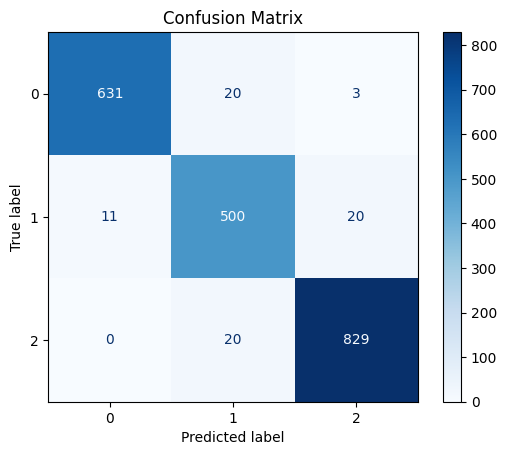

In [80]:
# Plot confusion matrix 
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

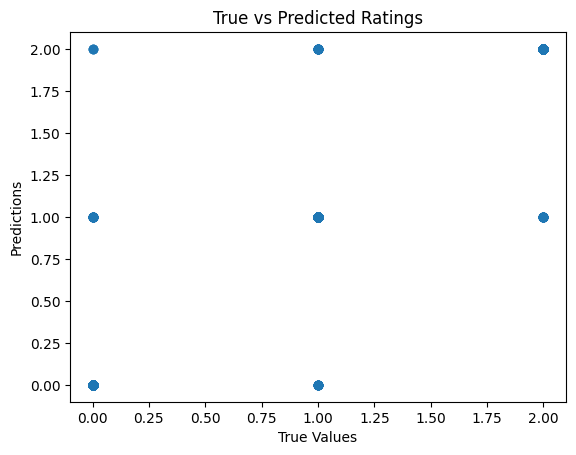

In [81]:
plt.scatter(y_test, y_pred)
plt.xlabel("True Values")
plt.ylabel("Predictions")
plt.title("True vs Predicted Ratings")
plt.show()

In [82]:
logreg = pipeline.named_steps["classifier"]

preprocessor = pipeline.named_steps["preprocessor"]

numeric_features = preprocessor.transformers_[0][2]

categorical_encoder = preprocessor.transformers_[1][1]
categorical_feature_names = preprocessor.transformers_[1][2]
encoded_cat_names = categorical_encoder.get_feature_names_out(categorical_feature_names)

all_feature_names = np.concatenate([numeric_features, encoded_cat_names])

coefficients = logreg.coef_[0]

feature_importance_df = pd.DataFrame({
    "Feature": all_feature_names,
    "Coefficient": coefficients,
    "Absolute Importance": np.abs(coefficients)
}).sort_values(by="Coefficient", ascending=False)




In [92]:
# Display top features
last_10 = feature_importance_df.tail(10)
top_10 = feature_importance_df.head(10)

In [88]:
y_pred

array([0, 2, 2, ..., 2, 2, 2])

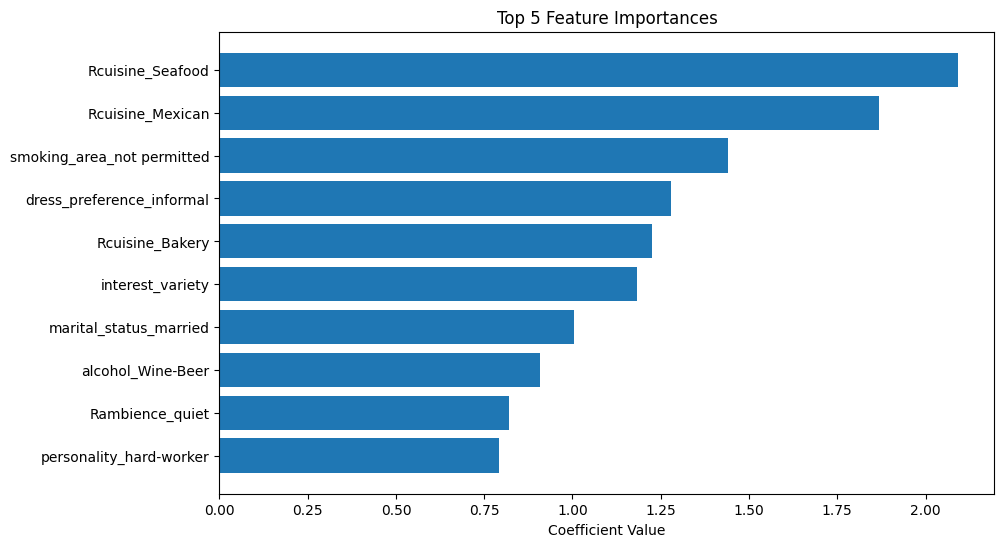

In [93]:
# Plotting feature importance
plt.figure(figsize=(10, 6))
plt.barh(top_10["Feature"], top_10["Coefficient"])
plt.xlabel("Coefficient Value")
plt.title("Top 5 Feature Importances")
plt.gca().invert_yaxis()
plt.show()

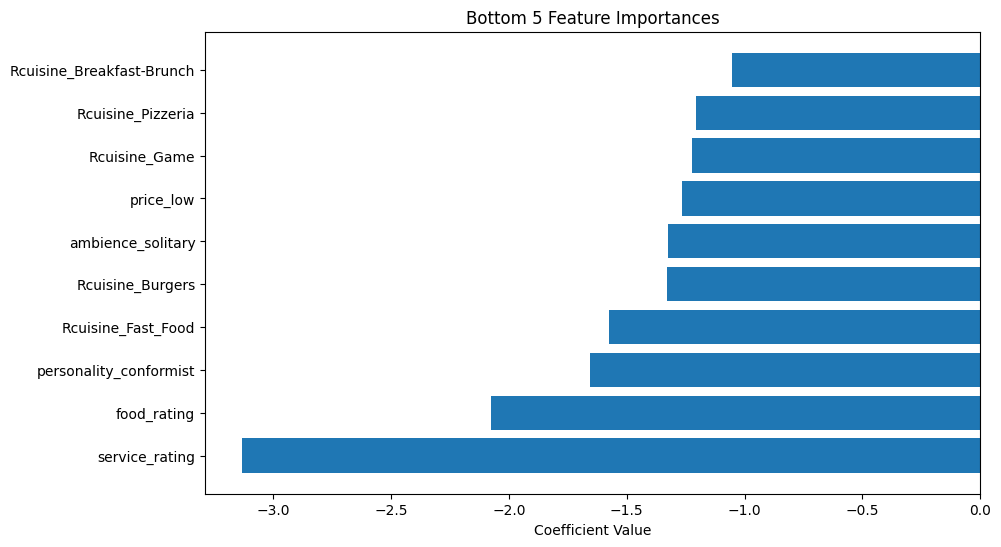

In [94]:
# Plotting feature importance
plt.figure(figsize=(10, 6))
plt.barh(last_10["Feature"], last_10["Coefficient"])
plt.xlabel("Coefficient Value")
plt.title("Bottom 5 Feature Importances")
plt.gca().invert_yaxis()
plt.show()